In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
!pip install mne

In [3]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import signal
import math
import mne
%matplotlib inline

In [4]:
epochs = mne.read_epochs('/content/drive/MyDrive/BCI/BCICompetition/data/Train_set/oddball_train_epo.fif')

Reading /content/drive/MyDrive/BCI/BCICompetition/data/Train_set/oddball_train_epo.fif ...
    Found the data of interest:
        t =    -300.00 ...     700.00 ms
        0 CTF compensation matrices available
Not setting metadata
3420 matching events found
No baseline correction applied
0 projection items activated


## Sub Sampling

In [5]:
# Reducir la frecuencia de muestreo a 100 Hz
epochs_resampled = epochs.copy().resample(125)

In [6]:
n_data1 = epochs[0].get_data()
n_data1[0][0].size

241

In [7]:
epochs_resampled[0].get_data().size
n_data2 = epochs_resampled[0].get_data()
n_data2[0][0].size

126

In [8]:
epochs_resampled.save('/content/drive/MyDrive/BCI/BCICompetition/data/Train_set/oddball_subsampl_epo.fif',overwrite=True)

Overwriting existing file.


## Se balancea el set de datos

In [9]:
event_dict = {"NoP300":0,"P300":1}
epochs_equalized = epochs_resampled.copy()
epochs_equalized.equalize_event_counts(event_dict)

Dropped 2280 epochs: 0, 1, 4, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 47, 52, 53, 54, 55, 56, 57, 58, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 76, 77, 78, 79, 82, 83, 86, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 106, 111, 112, 113, 114, 117, 118, 119, 122, 123, 124, 125, 126, 129, 130, 131, 132, 133, 136, 137, 138, 139, 140, 143, 146, 149, 150, 151, 152, 153, 154, 155, 156, 157, 160, 161, 162, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 180, 181, 182, 183, 184, 187, 188, 191, 192, 193, 194, 195, 196, 197, 198, 203, 204, 205, 210, 211, 212, 213, 214, 215, 218, 219, 220, 221, 222, 225, 226, 227, 228, 229, 230, 231, 232, 235, 236, 239, 240, 241, 242, 243, 244, 245, 246, 247, 250, 253, 254, 255, 256, 257, 258, 263, 264, 265, 266, 267, 268, 269, 274, 275, 276, 277, 278, 279, 282, 283, 284, 285, 286, 291, 292, 295, 296, 297, 298, 299, 300, 301, 302, 305, 308, 309, 310, 311, 312, 313, 314

(<EpochsFIF |  1140 events (all good), -0.3 – 0.7 s, baseline -0.3 – 0 s, ~70.2 MB, data loaded,
  'NoP300': 570
  'P300': 570>,
 array([   0,    1,    4, ..., 3417, 3418, 3419]))

In [10]:
epochs_equalized['P300']

Number of events,570
Events,P300: 570
Time range,-0.300 – 0.700 s
Baseline,-0.300 – 0.000 s


In [11]:
epochs_equalized['NoP300']

Number of events,570
Events,NoP300: 570
Time range,-0.300 – 0.700 s
Baseline,-0.300 – 0.000 s


In [12]:
print(type(epochs))

<class 'mne.epochs.EpochsFIF'>


## Se agrupan los electrodos segun la zona de la corteza cerebral

In [30]:
info = epochs_equalized.info
ch_names = info['ch_names']
electrodos_C = [ch_name for ch_name in ch_names if ch_name.startswith('C')] #.startswith('C')
electrodos_O = [ch_name for ch_name in ch_names if 'O' in ch_name]
electrodos_P = [ch_name for ch_name in ch_names if ch_name.startswith('P')]
#electrodos_C, electrodos_O, electrodos_P

In [31]:
S_O = epochs_equalized.copy().pick_channels(electrodos_O)
S_C = epochs_equalized.copy().pick_channels(electrodos_C)
S_P = epochs_equalized.copy().pick_channels(electrodos_P)
#S_O.info

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


In [48]:
data_OT = S_O["P300"].get_data()
data_CT = S_C["P300"].get_data()
data_PT = S_P["P300"].get_data()
print(data_OT.shape)
# Sumar los valores de los electrodos
mean_data_OT = data_OT.mean(axis=1)
mean_data_CT = data_CT.mean(axis=1)
mean_data_PT = data_PT.mean(axis=1)
mean_data_OT.shape, mean_data_CT.shape, mean_data_PT.shape

(570, 8, 126)


((570, 126), (570, 126), (570, 126))

In [49]:
data_OF = S_O["NoP300"].get_data()
data_CF = S_C["NoP300"].get_data()
data_PF = S_P["NoP300"].get_data()
print(data_OT.shape)
# Sumar los valores de los electrodos
mean_data_OF = data_OF.mean(axis=1)
mean_data_CF = data_CF.mean(axis=1)
mean_data_PF = data_PF.mean(axis=1)
mean_data_OF.shape, mean_data_CF.shape, mean_data_PF.shape

(570, 8, 126)


((570, 126), (570, 126), (570, 126))

In [62]:
# Concatenar los tres np.array a lo largo del segundo eje
data_T = np.concatenate((mean_data_OT[:, np.newaxis, :], mean_data_CT[:, np.newaxis, :], mean_data_PT[:, np.newaxis, :]), axis=1)
data_F = np.concatenate((mean_data_OF[:, np.newaxis, :], mean_data_CF[:, np.newaxis, :], mean_data_PF[:, np.newaxis, :]), axis=1)
data_T.shape, data_F.shape

((570, 3, 126), (570, 3, 126))

## Se vuelve a convertir a epocas

In [71]:
ch_names = ['O','C','P']
events = S_O['P300'].events
print(events[1])
ch_types = ['eeg','eeg','eeg']
sfreq = 125
info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)
epochs_T = mne.EpochsArray(data=data_T, info=info, events=events)

[834   0   1]
Not setting metadata
570 matching events found
No baseline correction applied
0 projection items activated


In [70]:
ch_names = ['O','C','P']
events = S_O['NoP300'].events
print(events[1])
ch_types = ['eeg','eeg','eeg']
sfreq = 125
info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)
epochs_F = mne.EpochsArray(data=data_F, info=info, events=events)

[876   0   0]
Not setting metadata
570 matching events found
No baseline correction applied
0 projection items activated


In [64]:
epochs_list = [epochs_T, epochs_F]
epochs_concatenated = mne.concatenate_epochs(epochs_list)

Not setting metadata
1140 matching events found
No baseline correction applied


In [75]:
epochs_shifted = epochs_concatenated.shift_time(-0.3)

In [79]:
epochs_shifted.save('/content/drive/MyDrive/BCI/BCICompetition/data/Train_set/elect_mean_epo.fif',overwrite=True)

Not setting metadata
570 matching events found
No baseline correction applied
0 projection items activated


<ipython-input-76-bc93fd8924c7>:1: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  epochs_shifted['1'].plot_image(picks=['O'])#P300


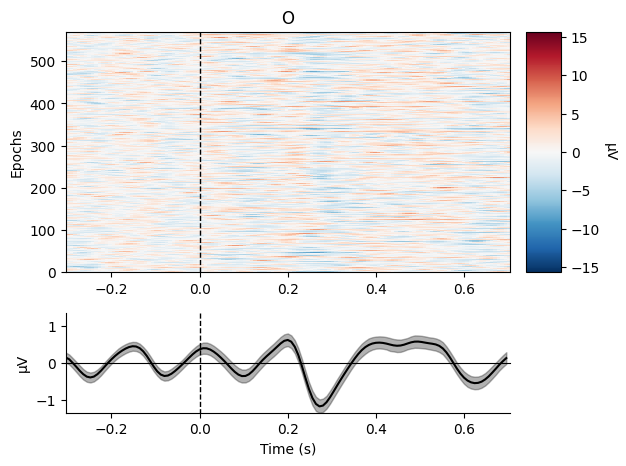

Not setting metadata
570 matching events found
No baseline correction applied
0 projection items activated


<ipython-input-76-bc93fd8924c7>:2: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  epochs_shifted['0'].plot_image(picks=['O'])#NoP300


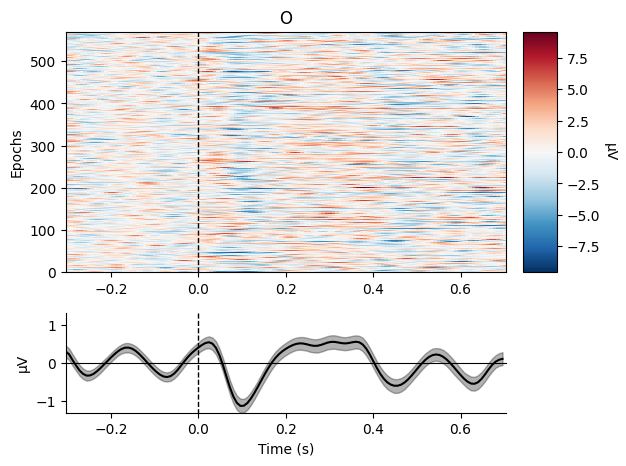

[<Figure size 640x480 with 3 Axes>]

In [76]:
epochs_shifted['1'].plot_image(picks=['O'])#P300
epochs_shifted['0'].plot_image(picks=['O'])#NoP300

Not setting metadata
570 matching events found
No baseline correction applied
0 projection items activated


<ipython-input-77-ac3baa63d0b2>:1: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  epochs_shifted['1'].plot_image(picks=['C'])#P300


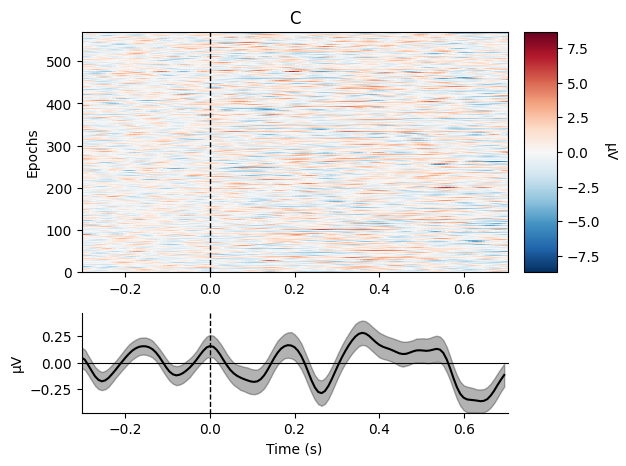

Not setting metadata
570 matching events found
No baseline correction applied
0 projection items activated


<ipython-input-77-ac3baa63d0b2>:2: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  epochs_shifted['0'].plot_image(picks=['C'])#NoP300


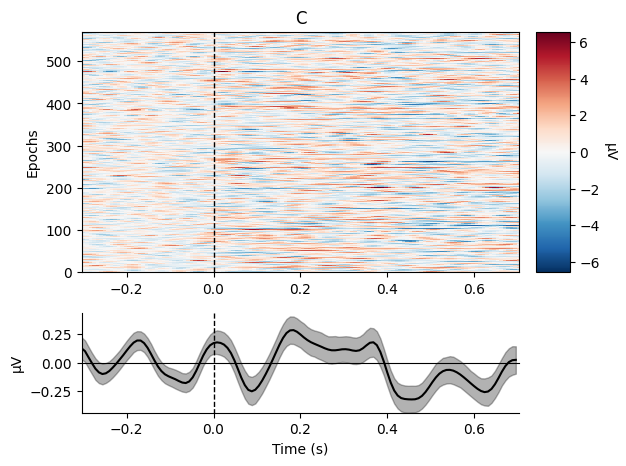

[<Figure size 640x480 with 3 Axes>]

In [77]:
epochs_shifted['1'].plot_image(picks=['C'])#P300
epochs_shifted['0'].plot_image(picks=['C'])#NoP300

Not setting metadata
570 matching events found
No baseline correction applied
0 projection items activated


<ipython-input-78-a4ddccaaaad9>:1: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  epochs_shifted['1'].plot_image(picks=['P'])#P300


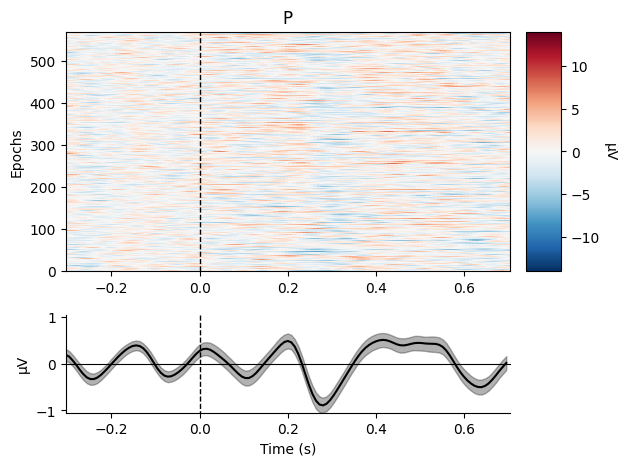

Not setting metadata
570 matching events found
No baseline correction applied
0 projection items activated


<ipython-input-78-a4ddccaaaad9>:2: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  epochs_shifted['0'].plot_image(picks=['P'])#NoP300


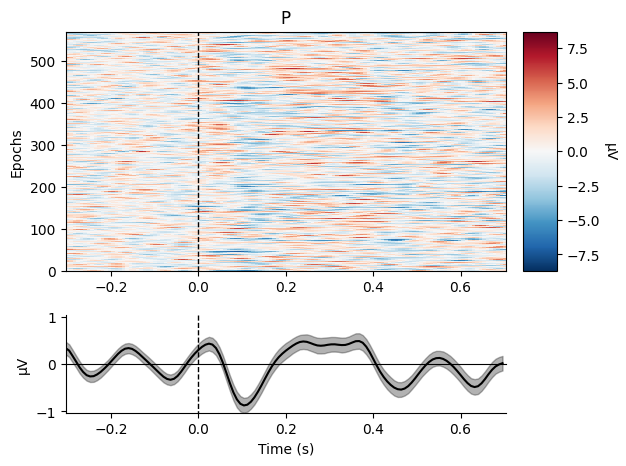

[<Figure size 640x480 with 3 Axes>]

In [78]:
epochs_shifted['1'].plot_image(picks=['P'])#P300
epochs_shifted['0'].plot_image(picks=['P'])#NoP300